In [125]:
import os

# torch
import torchvision
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
from torchvision import datasets
import torchvision.transforms.functional as TF
import torch
import random

# plot libraries
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns



from collections import Counter
from PIL import Image
import pandas as pd
from pathlib import Path
import numpy as np
import imagesize

In [53]:
random_seed = 10
torch.manual_seed(random_seed)

In [146]:
# paths
data_dir = '/Users/leticiaangulorojas/Documents/TESIS/cp-for-image-classifier/experiments/data/processed/crop_images'
data_dir_raw = "/Users/leticiaangulorojas/Documents/TESIS/cp-for-image-classifier/experiments/data/raw/Set1"
output_dir = "/Users/leticiaangulorojas/Documents/TESIS/cp-for-image-classifier/experiments/results/dataset"
animals = os.listdir(data_dir)
print("number of categories:", len(animals))

number of categories: 21


# Visualize data transformations

In [55]:
data_transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [56]:
def imshow(inp, title=None, ax=None, figsize=(15, 15)):
  """
  visualize a grid of images generated by the tensor
  """
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)
  ax.set_xticks([])
  ax.set_yticks([])
  if title is not None:
    ax.set_title(title,fontsize=20)
  

In [147]:
image_datasets = datasets.ImageFolder(os.path.join(data_dir_raw),transform=data_transform)
dataloader = torch.utils.data.DataLoader(image_datasets, 
                                         shuffle=True, 
                                         batch_size=32,
                                         num_workers=0)
#dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets.classes
print(class_names)

['1.02-Agouti', '1.03-Collared_Peccary', '1.06-Paca', '1.07-Red_Brocket_Deer', '1.08-White-nosed_Coati', '1.09-Spiny_Rat', '1.10-Ocelot', '1.14-Red_Squirrel', '1.19-Common_Opossum', '1.22-Bird_spec', '1.25-Great_Tinamou', '1.27-White_Tailed_Deer', '1.56-Mouflon', '1.57-Red_Deer', '1.58-Roe_Deer', '1.59-Wild_Boar', '1.60-Red_Fox', '1.63-European_Hare', '1.77-Wood_Mouse', '1.80-Coiban_Agouti']


In [58]:
# count how many images per species we have
image_dataset_targets = dict(Counter(image_datasets.targets))

dict_classes = image_datasets.class_to_idx

labeldict = {}
for name,number in dict_classes.items():
  labeldict[number] = name

dict_classes = image_datasets.class_to_idx
for key in dict_classes.keys():
    count = image_dataset_targets[dict_classes[key]]
    dict_classes[key] = count

dict_classes


{'agouti': 665,
 'bird_spec': 607,
 'coiban_agouti': 792,
 'collared_peccary': 774,
 'common_opossum': 702,
 'european_hare': 539,
 'great_tinamou': 1022,
 'mouflon': 2275,
 'ocelot': 436,
 'paca': 926,
 'red_brocket_deer': 889,
 'red_deer': 2621,
 'red_fox': 406,
 'red_squirrel': 421,
 'roe_deer': 1073,
 'spiny_rat': 524,
 'white-nosed_coati': 1102,
 'white_tailed_deer': 1900,
 'wild_boar': 1622,
 'wood_mouse': 973}

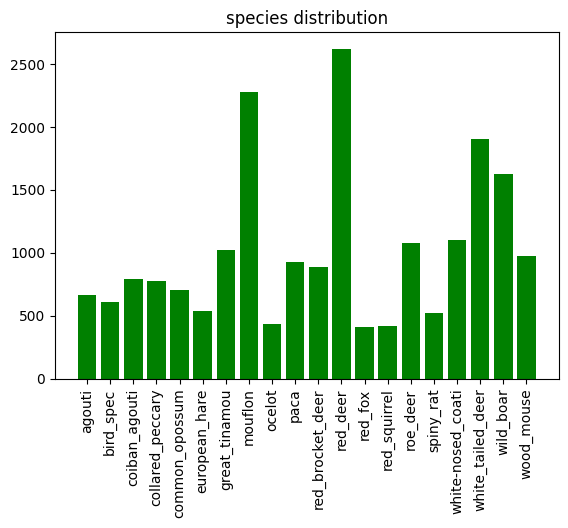

In [59]:
fig = plt.gcf()
fig.set_size_inches(6.5, 4.5)
plt.bar(dict_classes.keys(), dict_classes.values(), color='g')
plt.xticks(rotation=90)
plt.title("species distribution")
fig.savefig(os.path.join(output_dir,"dataset_class_distribution.png")) 
#sns.histplot(dict_classes.keys(), dict_classes.values())

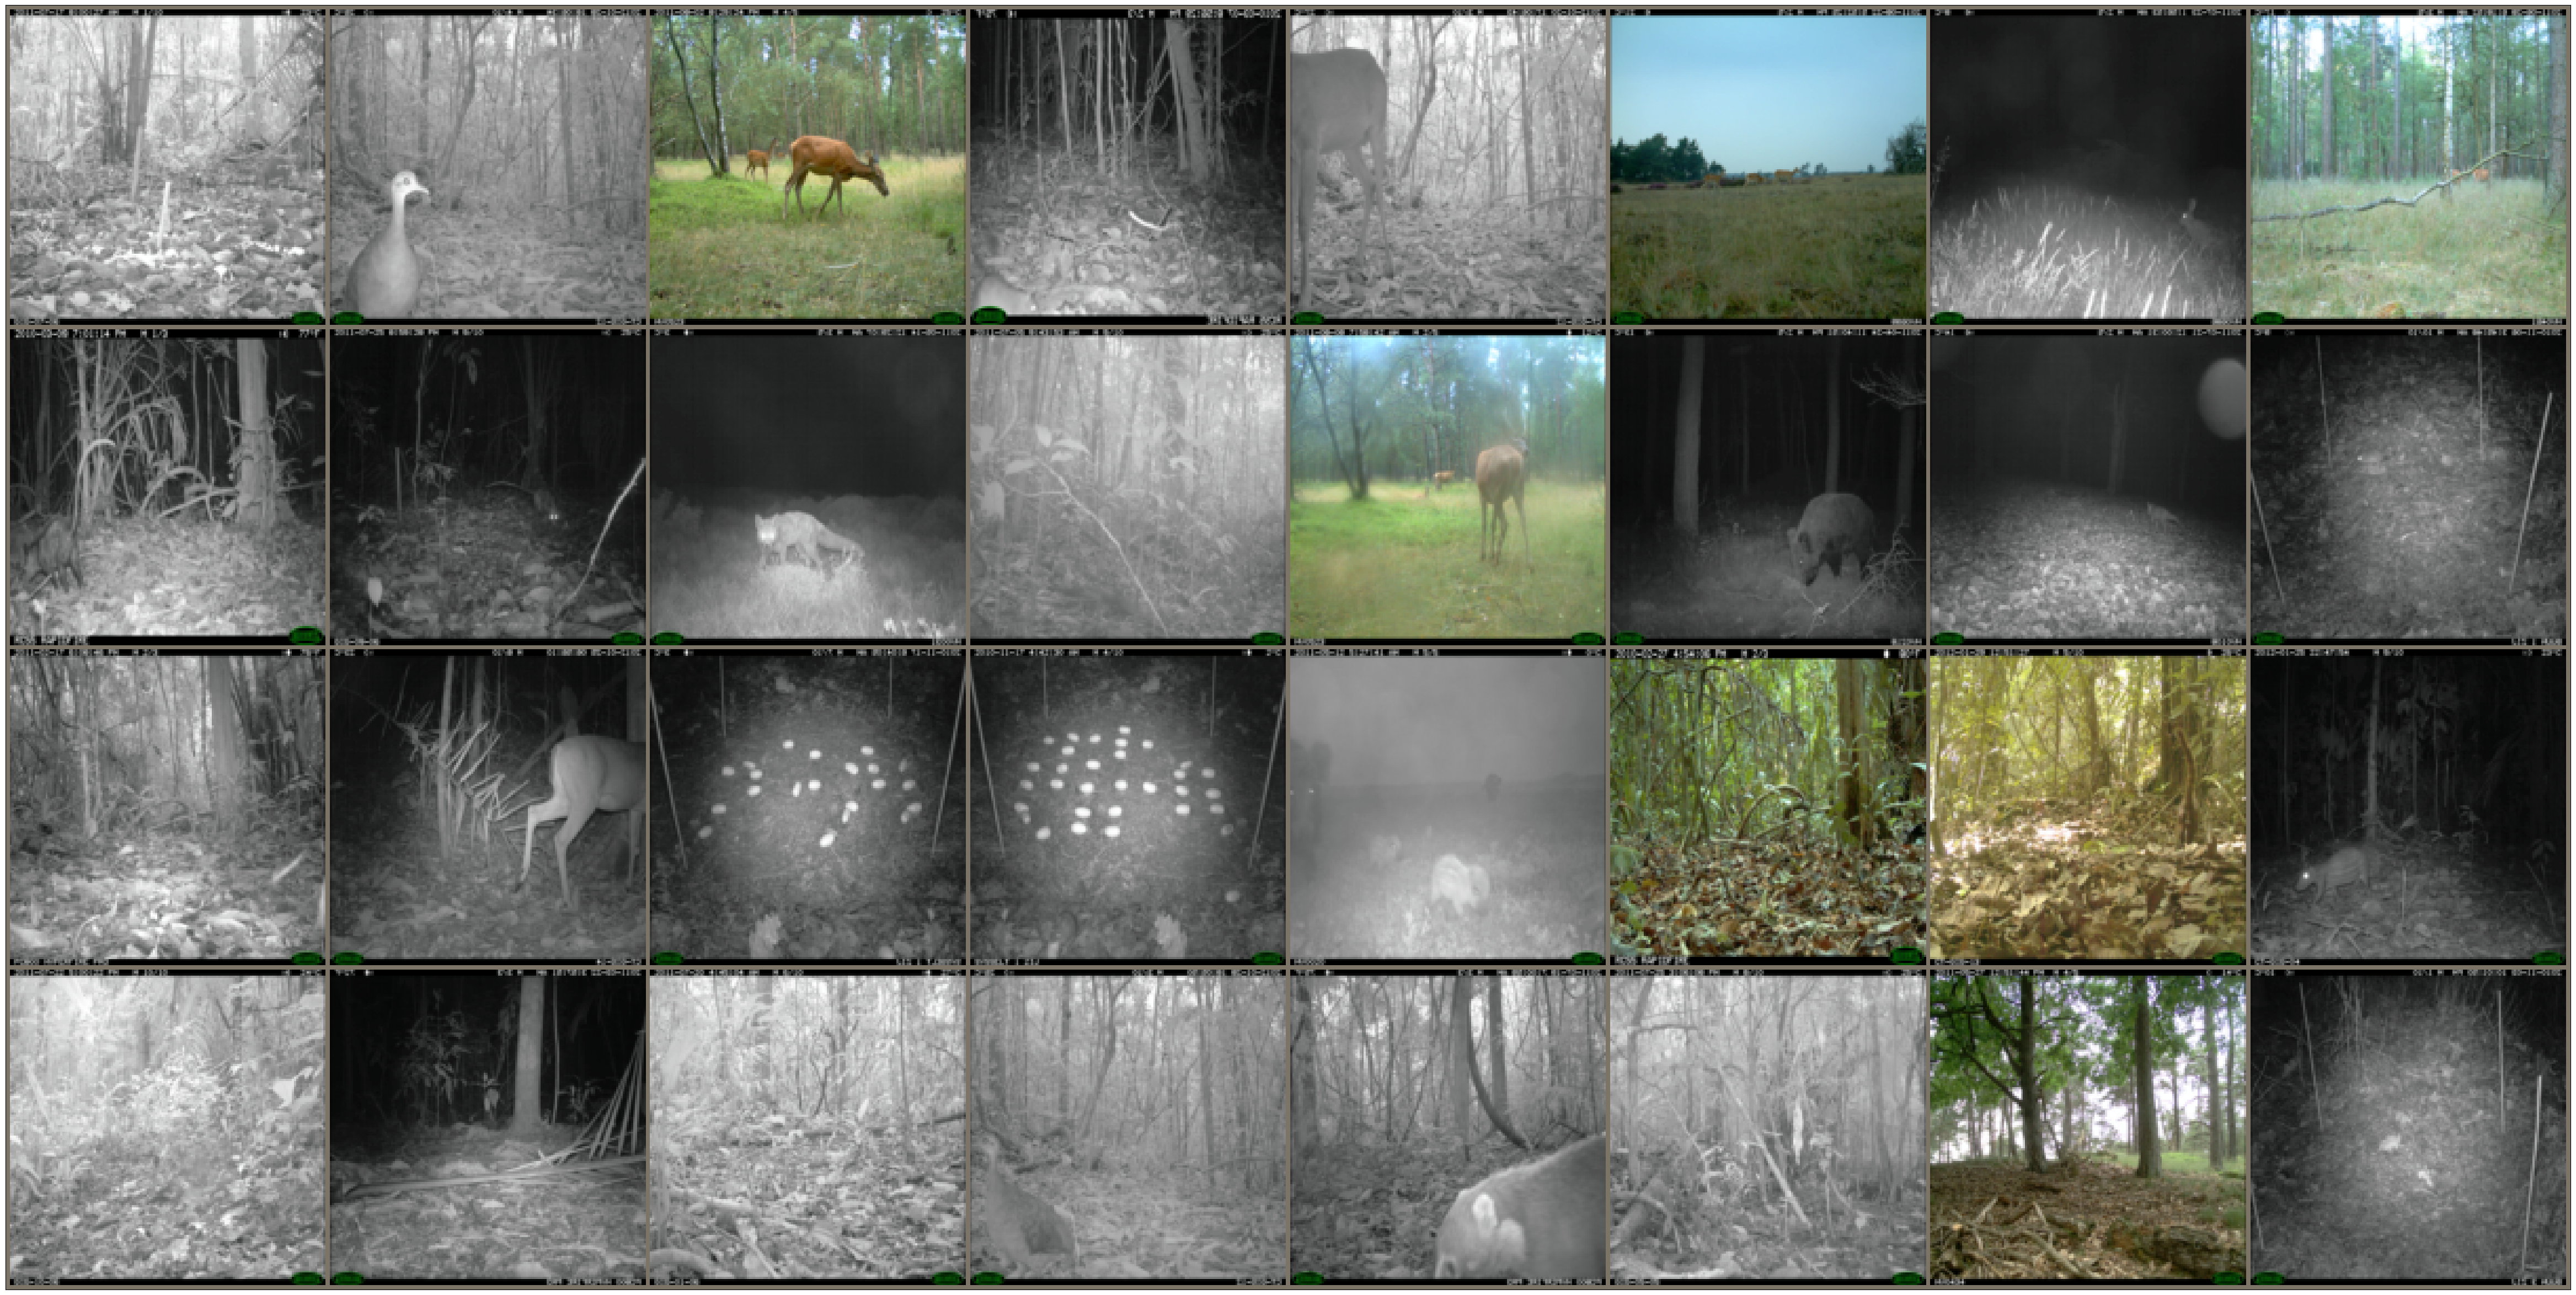

In [148]:
# Get a batch of training data
inputs, classes = next(iter(dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=8)

fig, ax = plt.subplots(1, figsize=(60, 60))
#imshow(out, title=[class_names[x] for x in classes], ax=ax)
imshow(out, ax=ax)

def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False,figsize=(15, 15))
    for i, img in enumerate(imgs):
        img = transforms.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

animals = ['/content/drive/MyDrive/Tesis/missouri/missourifiles/crops-model/train/Ocelot/35eb23e2-c90f-4996-a50a-12a12405a0d8.jpg',
           '/content/drive/MyDrive/Tesis/missouri/missourifiles/crops-model/train/Roe_deer/014224d3-daa3-4f2c-9c74-56f2730f99e5.jpg']
ORIG_IMAGE = Image.open(animals[1])

ORIG_IMAGE.size

In [64]:
def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    """
    authors: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
    verificar como se citan estas
    """
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False,figsize=(15, 15))
    for row_idx, row in enumerate(imgs):
        row = [ORIG_IMAGE] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

## Transformations

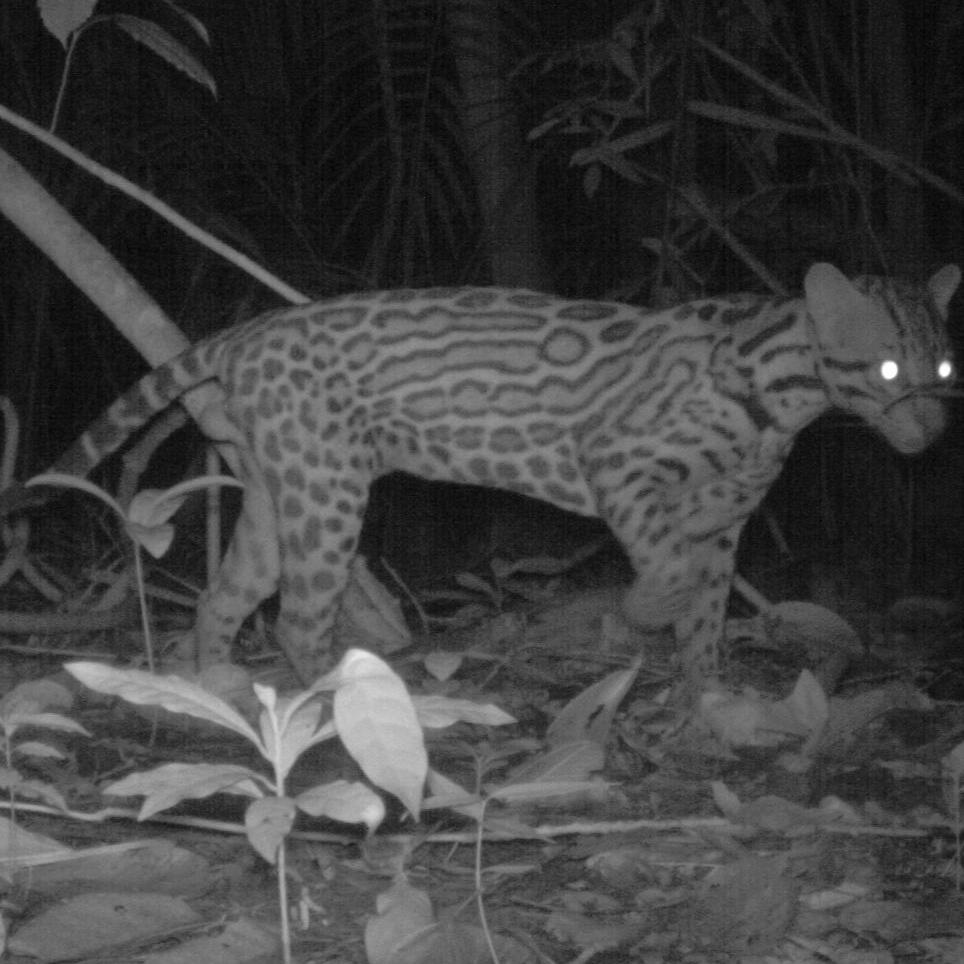

In [80]:
# Get the Image Resolutions
animals = os.listdir(data_dir)
roots = [os.path.join(data_dir,x) for x in animals ]
root = roots[1]
imgs = [img.name for img in Path(root).iterdir() if img.suffix == ".jpg"]
paths_imgs = [os.path.join(root,f) for f in imgs]
ORIG_IMAGE = Image.open(paths_imgs[30]) #100
ORIG_IMAGE

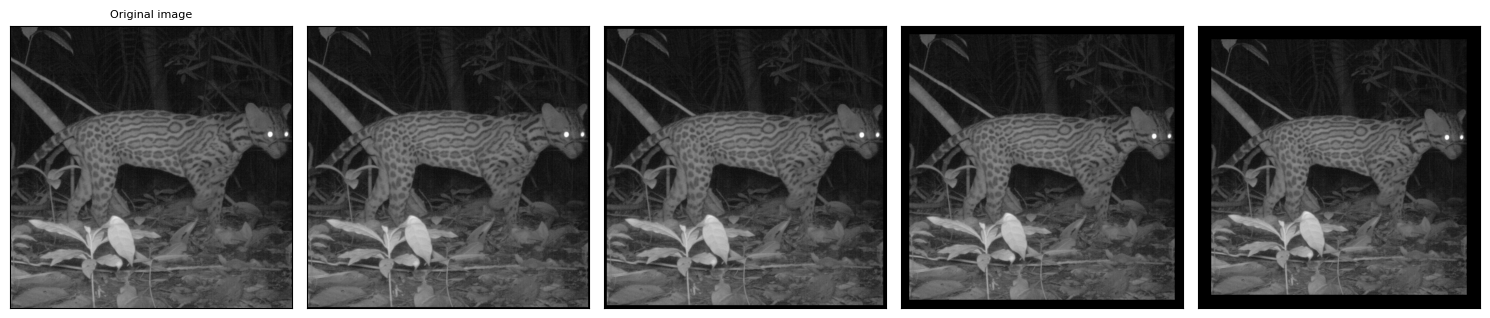

In [81]:
# pad
padded_imgs = [transforms.Pad(padding=padding)(ORIG_IMAGE) for padding in (3, 10, 30, 50)]
plot(padded_imgs)

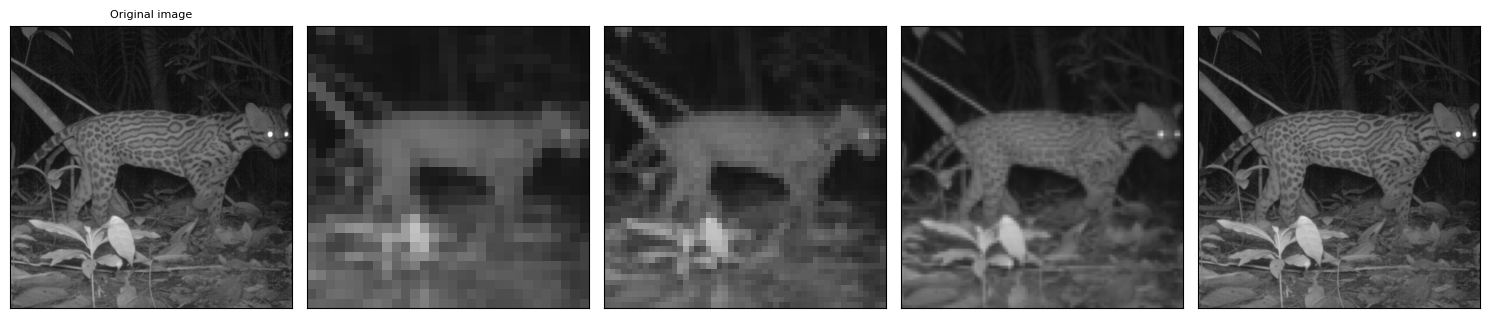

In [82]:
# Resize
resized_imgs = [transforms.Resize(size=size)(ORIG_IMAGE) for size in (30, 50, 100, ORIG_IMAGE.size)]
plot(resized_imgs)

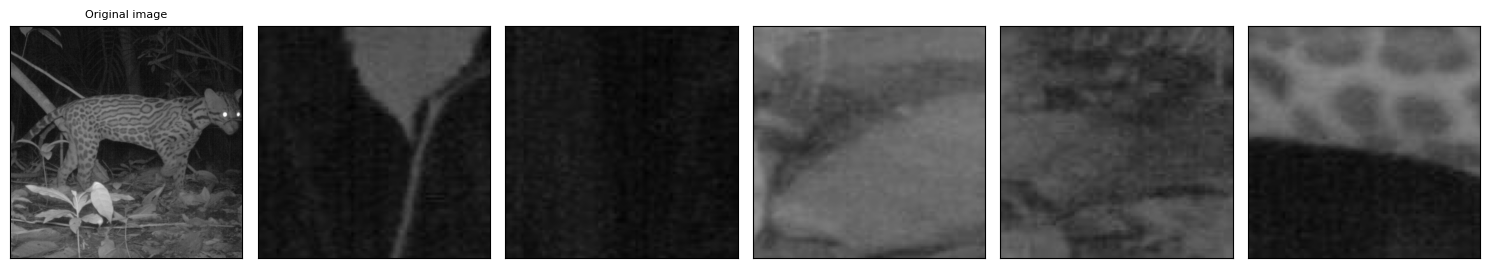

In [83]:
# five crop
(top_left, top_right, bottom_left, bottom_right, center) = transforms.FiveCrop(size=(100, 100))(ORIG_IMAGE)
plot([top_left, top_right, bottom_left, bottom_right, center])

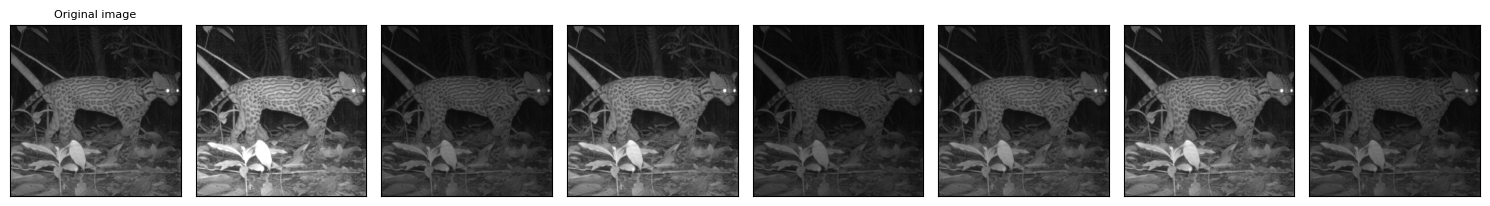

In [105]:
# Jitter
jitter = transforms.ColorJitter(brightness=.5, hue=.5)
jitted_imgs = [jitter(ORIG_IMAGE) for _ in range(7)]
plot(jitted_imgs)

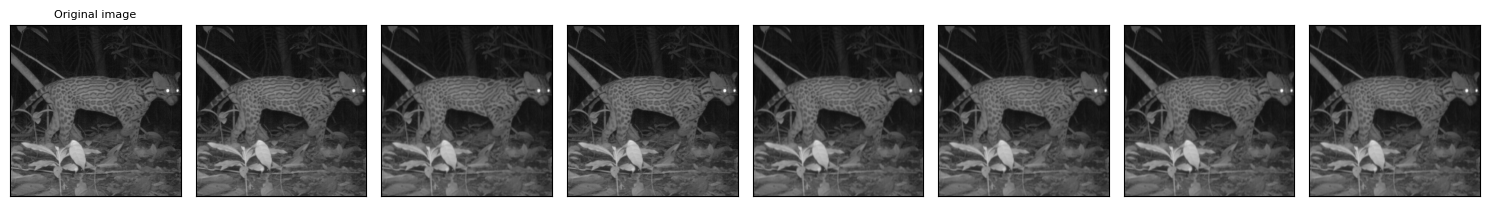

In [149]:
blurrer = transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.7, 7))
blurred_imgs = [blurrer(ORIG_IMAGE) for _ in range(7)]
plot(blurred_imgs)

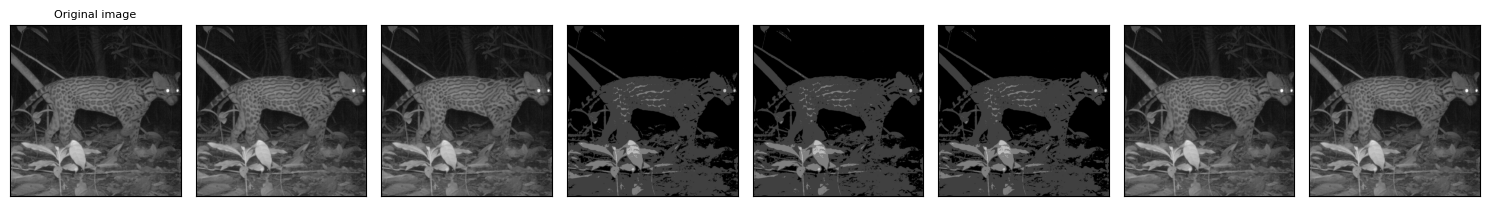

In [153]:
posterizer = transforms.RandomPosterize(bits=2)
posterized_imgs = [posterizer(ORIG_IMAGE) for _ in range(7)]
plot(posterized_imgs)

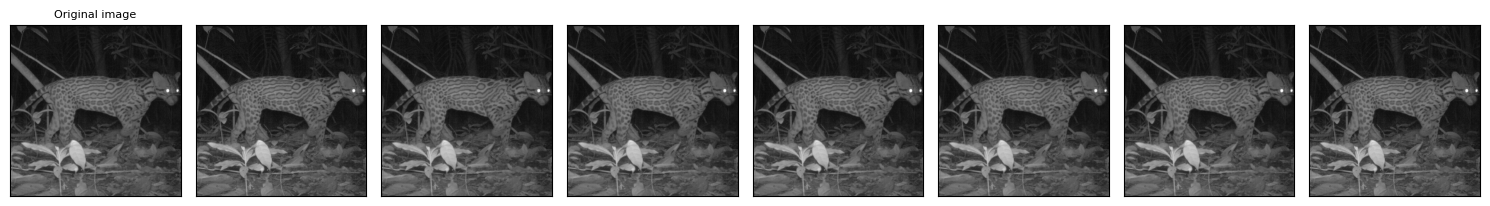

In [107]:
sharpness_adjuster = transforms.RandomAdjustSharpness(sharpness_factor=3)
sharpened_imgs = [sharpness_adjuster(ORIG_IMAGE) for _ in range(7)]
plot(sharpened_imgs)

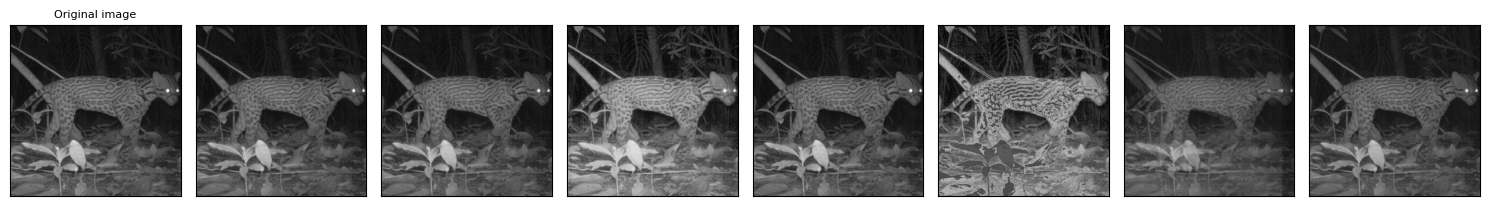

In [100]:
augmenter = transforms.AugMix()
imgs = [augmenter(ORIG_IMAGE) for _ in range(7)]
plot(imgs)

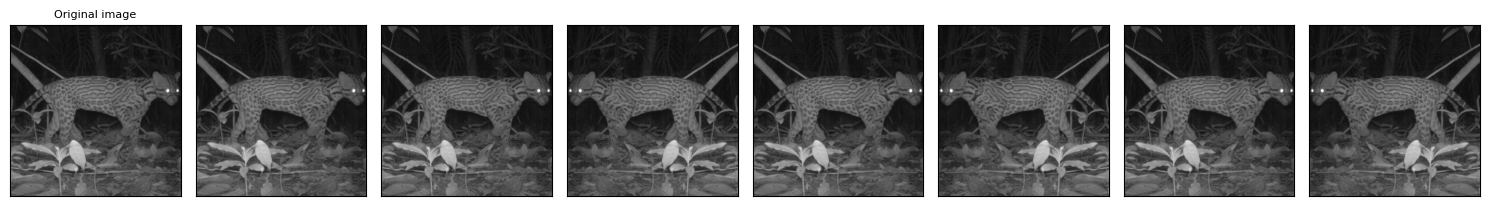

In [101]:
hflipper = transforms.RandomHorizontalFlip(p=0.5)
transformed_imgs = [hflipper(ORIG_IMAGE) for _ in range(7)]
plot(transformed_imgs)

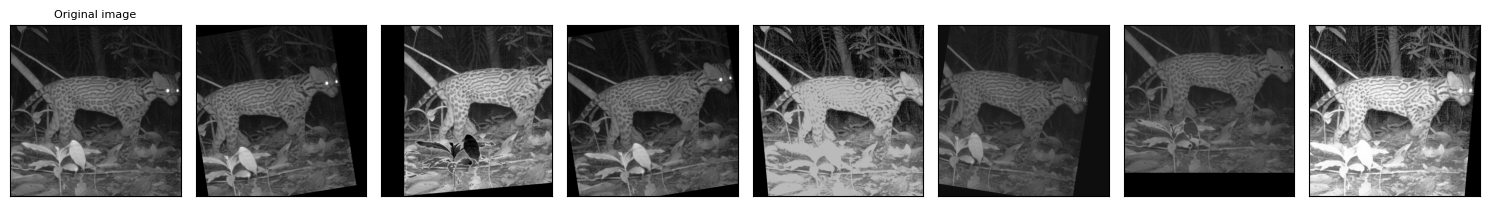

In [99]:
augmenter = transforms.RandAugment(num_ops=5)
imgs = [augmenter(ORIG_IMAGE) for _ in range(7)]
plot(imgs)

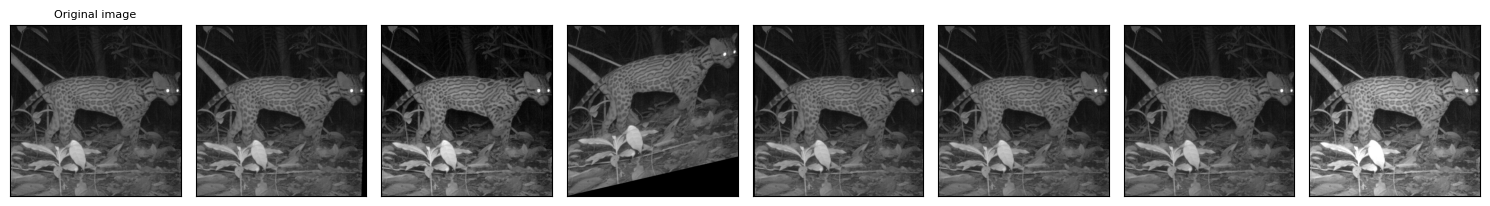

In [102]:
augmenter = transforms.TrivialAugmentWide()
imgs = [augmenter(ORIG_IMAGE) for _ in range(7)]
plot(imgs)

In [108]:
class MyRotationTransform:
    """Rotate by one of the given angles."""

    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return TF.rotate(x, angle)

class MyEqualizerTransform:
    """Rotate by one of the given angles."""

    def __init__(self, arg1=None, arg2=None):
        self.__arg1 = arg1
        self.__arg2 = arg2

    def __call__(self, x):
        return TF.equalize(x)

In [111]:
#rotation_transform = MyRotationTransform(angles=[-30, -15, 0, 15, 30])
equalizer_transforms = MyEqualizerTransform()

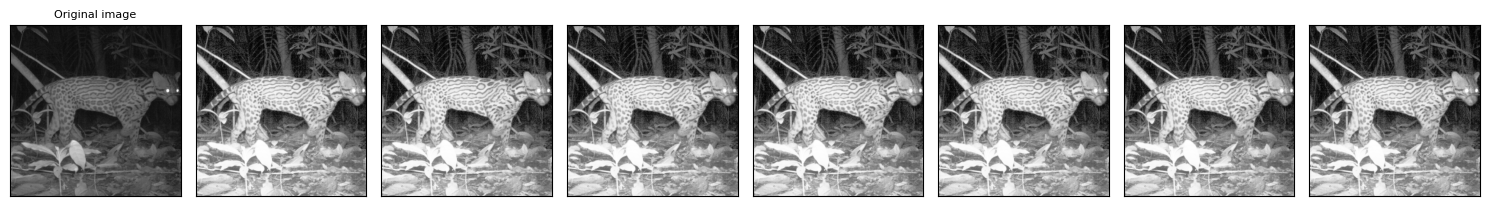

In [112]:
#equalizer = TF.equalize(ORIG_IMAGE)
equalized_imgs = [equalizer_transforms (ORIG_IMAGE) for _ in range(7)]
plot(equalized_imgs)

In [ ]:
animals = ['/content/drive/MyDrive/Tesis/missouri/missourifiles/crops-model/train/Ocelot/35eb23e2-c90f-4996-a50a-12a12405a0d8.jpg',
           '/content/drive/MyDrive/Tesis/missouri/missourifiles/crops-model/train/Roe_deer/014224d3-daa3-4f2c-9c74-56f2730f99e5.jpg']
ORIG_IMAGE = Image.open(animals[0])

In [118]:
os.listdir(data_dir)

['wild_boar',
 'ocelot',
 'european_hare',
 'red_brocket_deer',
 'red_deer',
 'coiban_agouti',
 'bird_spec',
 'red_fox',
 'agouti',
 'white_tailed_deer',
 'mouflon',
 'common_opossum',
 'wood_mouse',
 'great_tinamou',
 'white-nosed_coati',
 'roe_deer',
 'collared_peccary',
 'paca',
 'red_squirrel',
 'spiny_rat']

In [119]:
# Get the Image Resolutions
root = data_dir
animals = os.listdir(data_dir)

transform = transforms.Compose([
    transforms.ToTensor()
])


roots = [os.path.join(data_dir,x) for x in animals ]

imgs = [img.name for img in Path(root).iterdir() if img.suffix == ".jpg"]
img_meta = {}
for f in imgs: img_meta[str(f)] = imagesize.get(os.path.join(root,f))

list_df = []
for root in roots:
    imgs = [img.name for img in Path(root).iterdir() if img.suffix == ".jpg"]
    img_mean = {}
    for f in imgs: img_meta[str(f)] = imagesize.get(os.path.join(root,f))
    img_meta_df = pd.DataFrame.from_dict([img_meta]).T.reset_index().set_axis(['FileName', 'Size'], axis='columns', inplace=False)
    img_meta_df[["Width", "Height"]] = pd.DataFrame(img_meta_df["Size"].tolist(), index=img_meta_df.index)
    list_df.append(img_meta_df)

print(f'Total Nr of Images in the dataset: {len(img_meta_df)}')
img_meta_df.head()

Total Nr of Images in the dataset: 20269


FileName          Size  Width  Height
0  0220637a-a9e1-4c30-9e35-8b0cdfe0e6f5.jpg    (114, 114)    114     114
1  5bb80be2-b0f5-47f8-8005-9a5bd8c6e1b0.jpg    (131, 131)    131     131
2  8566080a-0e09-4f38-85d2-cba2bc74d057.jpg    (395, 395)    395     395
3  8eaea9b3-3b68-46e7-90af-78eda1f043b4.jpg    (334, 334)    334     334
4  555acf17-5a53-4fdc-9c8f-42576c62261c.jpg  (1195, 1195)   1195    1195

In [121]:
print(np.sort([np.mean(list_df[i].Width) for i in range(len(list_df))]))
print(np.median([np.mean(list_df[i].Width) for i in range(len(list_df))]))

[401.18618989 454.92414324 471.4174118  474.86491035 480.82215743
 481.30988209 483.43908126 485.09399848 486.57128294 487.57400124
 487.6421882  488.9493872  489.25412362 489.55965622 490.93243831
 494.29374641 495.55395683 500.75300768 530.56476175 531.32041615]
487.6080947193988


In [122]:
list_df[0].max()
list_df[0].min()
#np.max(list_df[0])
list_df[0]

FileName          Size  Width  Height
0     0220637a-a9e1-4c30-9e35-8b0cdfe0e6f5.jpg    (114, 114)    114     114
1     5bb80be2-b0f5-47f8-8005-9a5bd8c6e1b0.jpg    (131, 131)    131     131
2     8566080a-0e09-4f38-85d2-cba2bc74d057.jpg    (395, 395)    395     395
3     8eaea9b3-3b68-46e7-90af-78eda1f043b4.jpg    (334, 334)    334     334
4     555acf17-5a53-4fdc-9c8f-42576c62261c.jpg  (1195, 1195)   1195    1195
...                                        ...           ...    ...     ...
1617  4b89c8b2-0f67-4c8c-afef-64255a537540.jpg    (174, 175)    174     175
1618  a9913713-d2be-44e5-a4c7-01fcf9a49d78.jpg  (1304, 1304)   1304    1304
1619  f28f625e-db85-4782-85f3-6079710da064.jpg    (504, 504)    504     504
1620  7797cf37-1e29-4a50-b9b8-ed15e184b427.jpg    (699, 699)    699     699
1621  74e4c885-2e97-4f00-86ac-881ba1a5d8a1.jpg    (630, 630)    630     630

[1622 rows x 4 columns]

In [126]:
df_big = pd.concat([
                    list_df[0],list_df[1], list_df[2],list_df[2],
                    list_df[3],list_df[4],list_df[5],list_df[6],
                    list_df[7],list_df[8],list_df[9],list_df[10],
                    list_df[11],list_df[12],list_df[13]
                    ], ignore_index=True)

<Axes: xlabel='Width', ylabel='Count'>

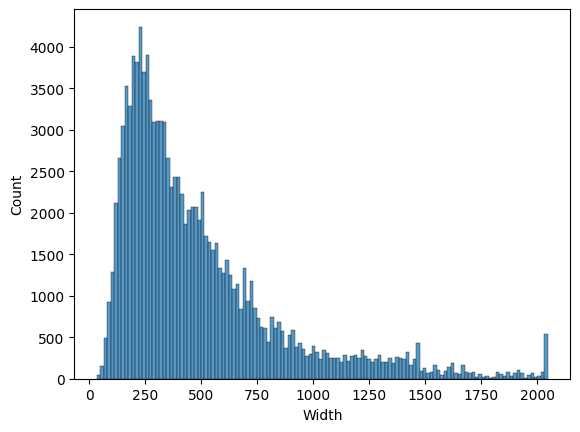

In [129]:
sns.histplot(data=df_big, x="Width")

In [131]:
from scipy import stats as st
print(df_big.describe())
print(st.mode(df_big['Width'],keepdims=True))
print(np.median(df_big['Width']))

               Width         Height
count  115920.000000  115920.000000
mean      488.526924     479.227907
std       366.793609     338.081203
min        34.000000      34.000000
25%       234.000000     234.000000
50%       375.000000     375.000000
75%       613.000000     613.000000
max      2048.000000    1536.000000
ModeResult(mode=array([224]), count=array([448]))
375.0


# Normalization

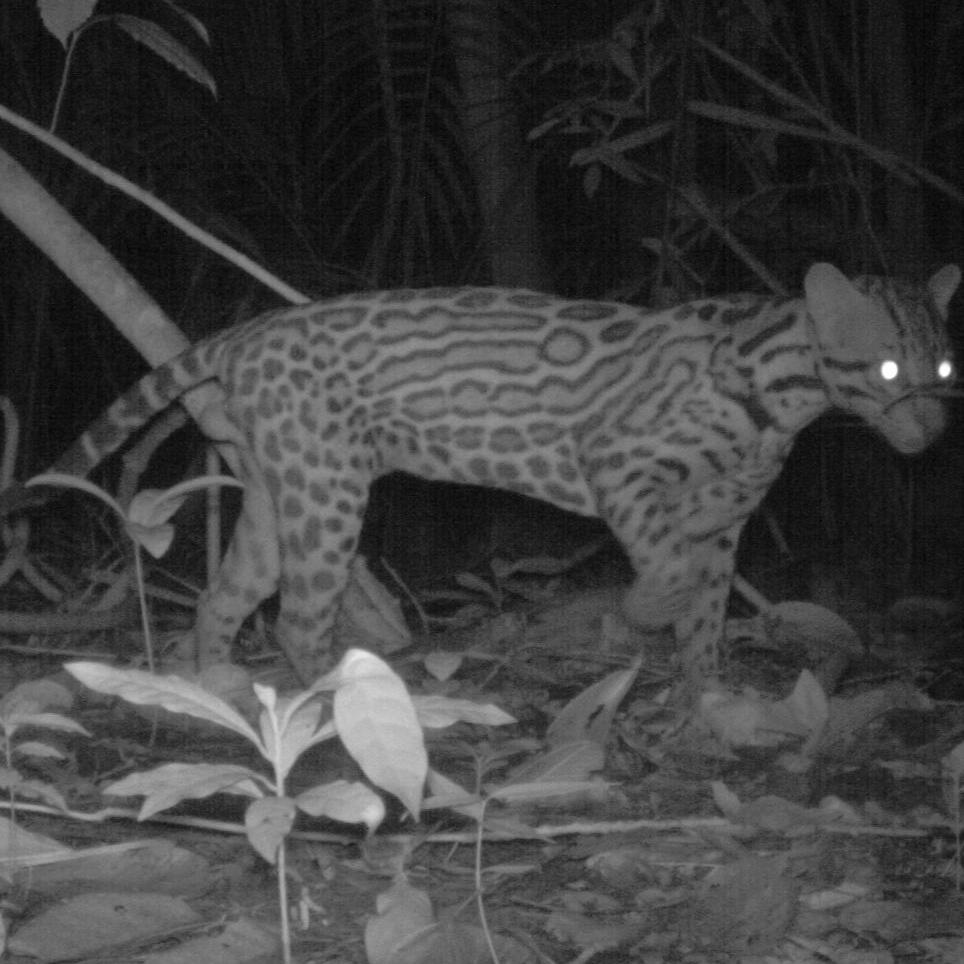

In [140]:
# Get the Image Resolutions
animals = os.listdir(data_dir)
roots = [os.path.join(data_dir,x) for x in animals ]
root = roots[1]
imgs = [img.name for img in Path(root).iterdir() if img.suffix == ".jpg"]
paths_imgs = [os.path.join(root,f) for f in imgs]
img = Image.open(paths_imgs[30])
img

Text(0.5, 1.0, 'distribution of pixels')

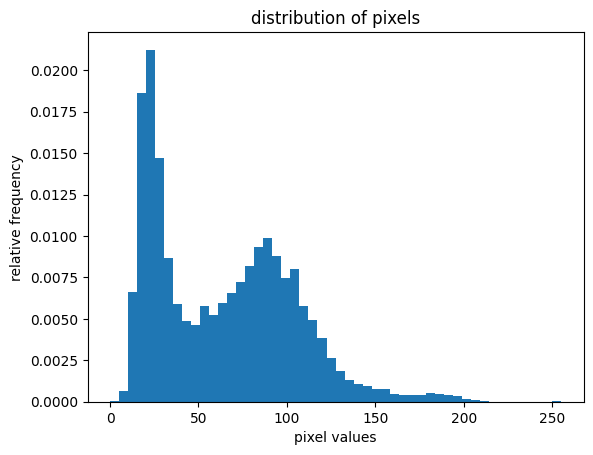

In [141]:
# convert PIL image to numpy array
img_np = np.array(img)

# plot the pixel values
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

Text(0.5, 1.0, 'distribution of pixels')

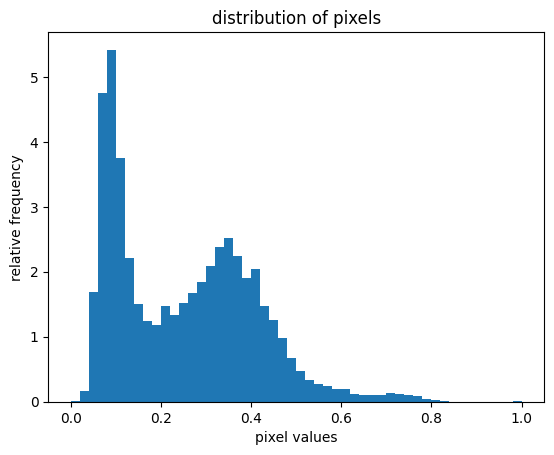

In [142]:
# define custom transform function
transform = transforms.Compose([
    transforms.ToTensor()
])

# transform the pIL image to tensor
# image
img_tr = transform(img)

# Convert tensor image to numpy array
img_np = np.array(img_tr)

# plot the pixel values
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

We find that pixel values of tensor image range from 0.0 to 1.0. We notice that the pixel distributions of RBG and tensor image look the same but differ in the pixel values range.

In [143]:
# Python code to calculate mean and std
# of image

# get tensor image
img_tr = transform(img)

# calculate mean and std
mean, std = img_tr.mean([1,2]), img_tr.std([1,2])

# print mean and std
print("mean and std before normalize:")
print("Mean of the image:", mean)
print("Std of the image:", std)
# The mean and std of ImageNet are: mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]

mean and std before normalize:
Mean of the image: tensor([0.2518, 0.2518, 0.2518])
Std of the image: tensor([0.1564, 0.1564, 0.1564])


Here we calculated the mean and std of the image for all three channels Red, Green, and Blue. These values are before normalization.  We will use these values to normalize the image.

To **normalize the image**, here we use the above calculated mean and std of the image. We can also use the mean and std of the ImageNet dataset if the image is similar to ImageNet images. The mean and std of ImageNet are: mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. If the image is not similar to ImageNet, like medical images, then it is always advised to calculate the mean and std of the dataset and use them to normalize the images.

Text(0.5, 1.0, 'distribution of pixels')

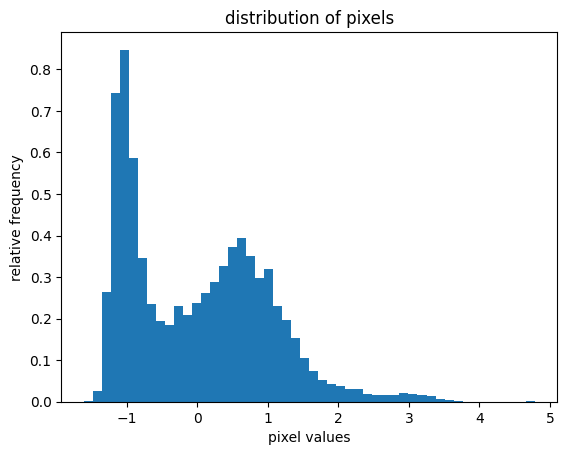

In [144]:
from torchvision import transforms

# define custom transform
# here we are using our calculated
# mean & std
transform_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# get normalized image
img_normalized = transform_norm(img)

# convert normalized image to numpy
# array
img_np = np.array(img_normalized)

# plot the pixel values
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

## Visualize the normalized image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


([], [])

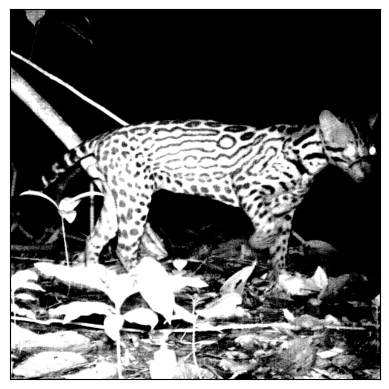

In [145]:
# Python Code to visualize normalized image

# get normalized image
img_normalized = transform_norm(img)

# convert this image to numpy array
img_normalized = np.array(img_normalized)

# transpose from shape of (3,,) to shape of (,,3)
img_normalized = img_normalized.transpose(1, 2, 0)

# display the normalized image
plt.imshow(img_normalized)
plt.xticks([])
plt.yticks([])

# Calculate population mean and std

In [ ]:
# Identify Image Resolutions
# Import Packages
import pandas as pd
import matplotlib.pyplot  as plt
from PIL import Image
from pathlib import Path
import numpy as np

# Get the Image Resolutions
data_dir = '/LUSTRE/users/ecoinf_admin/conabio_ml_vision/examples/classification/missouri/missouri_new_files/crop_images'
animals = os.listdir(data_dir)

transform = transforms.Compose([
    transforms.ToTensor()
])


roots = [os.path.join(data_dir,x) for x in animals ]

#imgs = [img.name for img in Path(root).iterdir() if img.suffix == ".jpg"]

#for f in imgs: img_meta[str(f)] = imagesize.get(os.path.join(root,f))
img_mean = {}
img_std = {}
list_df = []
for root in roots:
    imgs = [img.name for img in Path(root).iterdir() if img.suffix == ".jpg"]
    # get tensor image
    # calculate mean and std
    #mean, std = img_tr.mean([1,2]), img_tr.std([1,2])
    for f in imgs: img_mean[str(f)] = transform(Image.open(os.path.join(root,f))).mean([1,2])
    for f in imgs: img_std[str(f)] = transform(Image.open(os.path.join(root,f))).std([1,2])
img_mean_df = pd.DataFrame.from_dict([img_mean]).T.reset_index().set_axis(['FileName', 'mean'], axis='columns', inplace=False)
img_std_df = pd.DataFrame.from_dict([img_std]).T.reset_index().set_axis(['FileName', 'std'], axis='columns', inplace=False)
    #img_meta_df[["Width", "Height"]] = pd.DataFrame(img_meta_df["Size"].tolist(), index=img_meta_df.index)
    #img_meta_df["std"] = img_tr.std([1,2])
    #list_df.append(img_meta_df)

#print(f'Total Nr of Images in the dataset: {len(img_meta_df)}')
#img_meta_df.head()
#img_meta_df

/tmp/ipykernel_5700/678675533.py:33: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  img_mean_df = pd.DataFrame.from_dict([img_mean]).T.reset_index().set_axis(['FileName', 'mean'], axis='columns', inplace=False)
/tmp/ipykernel_5700/678675533.py:34: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  img_std_df = pd.DataFrame.from_dict([img_std]).T.reset_index().set_axis(['FileName', 'std'], axis='columns', inplace=False)


In [ ]:
len(img_mean_df)

2900

In [ ]:
sumador_mean = torch.zeros(3)
sumador_std = torch.zeros(3)
for i in range(len(img_mean_df)):
    sumador_mean += img_mean_df.iloc[i]['mean']
    sumador_std += img_std_df.iloc[i]['std']
prom_mean = sumador_mean/len(img_mean_df)
prom_std = sumador_std/len(img_std_df)

In [ ]:
print('mean: ',prom_mean)
print('std: ',prom_std)

#Mean of the image: tensor([0.2347, 0.2347, 0.2347])
#Std of the image: tensor([0.1123, 0.1123, 0.1123])

mean:  tensor([0.3768, 0.3808, 0.3522])
std:  tensor([0.1328, 0.1349, 0.1317])


In [ ]:
print(img_mean_df.iloc[0]['mean'])
print(img_mean_df.iloc[1]['mean'])
(img_mean_df.iloc[0]['mean']+img_mean_df.iloc[1]['mean'])/2

tensor([0.3265, 0.3265, 0.3265])
tensor([0.3811, 0.3811, 0.3811])


tensor([0.3538, 0.3538, 0.3538])

In [ ]:
#applier = transforms.RandomApply(transforms=[transforms.Normalize(prom_mean, prom_std)], p=0.5)

In [ ]:
train_transform = transforms.Compose([
        transforms.Resize((500,500)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.RandomApply(transforms=[transforms.Normalize(prom_mean, prom_std)], p=0.7)
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

In [ ]:
transformed_imgs = [train_transform(img) for _ in range(10)]
#plot(transformed_imgs)

In [ ]:
imgs_ = []
for _ in range(4):
# convert this image to numpy array
  img_normalized = train_transform(img)
  img_normalized = np.array(img_normalized)

  # transpose from shape of (3,,) to shape of (,,3)
  img_normalized = img_normalized.transpose(1, 2, 0)
  imgs_.append(img_normalized)
  # display the normalized image

In [ ]:
def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False,figsize=(15, 15))
    for i, img in enumerate(imgs):
        #img = transforms.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


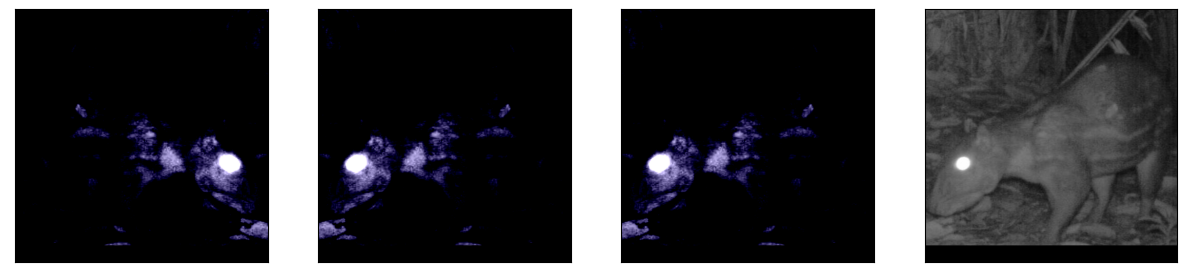

In [ ]:
show(imgs_)

In [ ]:
# upon every epoch you get a different version of the dataset
#https://stackoverflow.com/questions/51677788/data-augmentation-in-pytorch

In [ ]:
data_transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [ ]:
#2 calculate mean and std
image_size = 500

augs = transforms.Compose([transforms.Resize((image_size,image_size)),
                           transforms.ToTensor(),
                  transforms.Normalize(mean = [0, 0, 0],
                              std  = [1, 1, 1])
                          ])
# data loader
image_dataset = datasets.ImageFolder(os.path.join(data_dir),transform=augs)
image_loader = torch.utils.data.DataLoader(image_dataset, shuffle=True, batch_size=32,num_workers=0)

In [ ]:
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])
for i, batch in enumerate(image_loader):
    features = batch[0]
    labels  = batch[1]
    psum    += features.sum(axis        = [0, 2, 3])
    psum_sq += (features ** 2).sum(axis = [0, 2, 3])

In [ ]:
image_size =500
# pixel count
count = len(img_mean_df) * image_size * image_size

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))

mean: tensor([0.3768, 0.3809, 0.3522])
std:  tensor([0.1951, 0.1968, 0.1943])


In [ ]:
train_transform = transforms.Compose([
        transforms.Resize((500,500)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.RandomApply(transforms=[transforms.Normalize([0.3768, 0.3809, 0.3522],[0.1951, 0.1968, 0.1943]
                                                               )], p=0.8)
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    #Mean of the image: tensor([0.2347, 0.2347, 0.2347]) Std of the image: tensor([0.1123, 0.1123, 0.1123])
        ])


#transformed_imgs = [train_transform(img) for _ in range(10)]

imgs_ = []
for _ in range(4):
# convert this image to numpy array
  img_normalized = train_transform(img)
  img_normalized = np.array(img_normalized)

  # transpose from shape of (3,,) to shape of (,,3)
  img_normalized = img_normalized.transpose(1, 2, 0)
  imgs_.append(img_normalized)
  # display the normalized image

NameError: name 'img' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


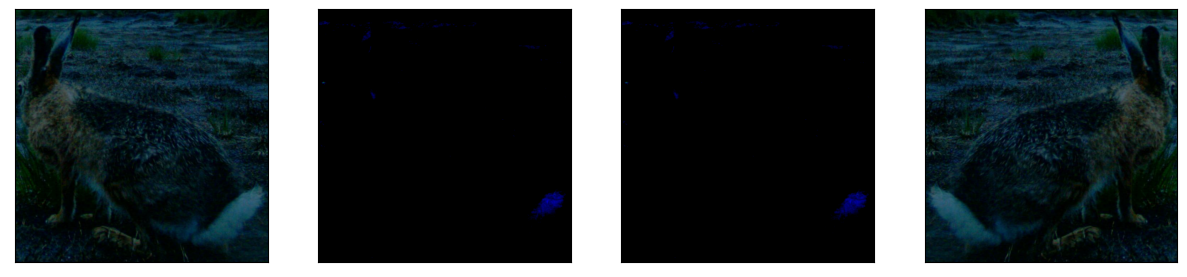

In [ ]:
show(imgs_)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


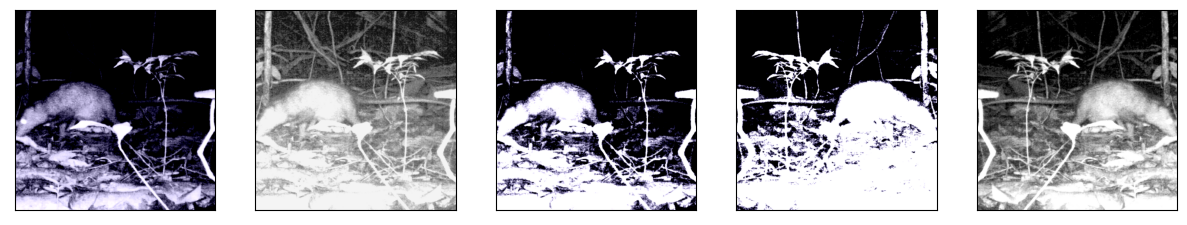

In [ ]:
train_transform = transforms.Compose([
        transforms.Resize((500,500)),
        transforms.RandomHorizontalFlip(p=0.5),
        MyEqualizerTransform(),
        #transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        transforms.ColorJitter(brightness=.3,contrast=0.5,saturation=0.59,hue=.3),
        transforms.ToTensor(),
        transforms.RandomApply(transforms=[
                                transforms.Normalize([0.3768, 0.3809, 0.3522],[0.1951, 0.1968, 0.1943]),
                                ],
                               p=0.6)
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    #Mean of the image: tensor([0.2347, 0.2347, 0.2347]) Std of the image: tensor([0.1123, 0.1123, 0.1123])
        ])

imgs_ = []
for _ in range(5):
# convert this image to numpy array
  img = ORIG_IMAGE
  img_normalized = train_transform(img)
  img_normalized = np.array(img_normalized)

  # transpose from shape of (3,,) to shape of (,,3)
  img_normalized = img_normalized.transpose(1, 2, 0)
  imgs_.append(img_normalized)
  # display the normalized image
show(imgs_)

## referencias
- https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/03/08/image-mean-std.html

In [ ]:
jitter = T.ColorJitter(brightness=.5, hue=.3)
jitted_imgs = [jitter(orig_img) for _ in range(4)]
plot(jitted_imgs)

In [ ]:
def save(*argv):
    return '-'.join(argv)

save('01','adam')

'01-adam'